# Γκαουσιανά Μοντέλα Μείξης

Ο αλγόριθμος συσταδοποίησης $k$-μέσων που είδαμε σε προηγούμενο εργαστήριο μπορεί να είναι απλός και εύκολα κατανοητός, ωστόσο η απλότητά του μπορεί να οδηγήσει σε συσταδοποιήσεις που έχουν μη-επιθυμητά χαρακτηριστικά.

Πιο συγκεκριμένα, η μη-πιθανοτική φύση του αλγορίθμου των $k$-μέσων καθώς και η χρήση απλών μετρικών απόστασης από το κέντρο της εκάστοτε συστάδας επιβάλλει περιορισμούς στο είδος των δεδομένων που μπορεί να περιγράψει ικανοποιητικά. 

Σε αυτό το notebook θα εξετάσουμε τα *Γκαουσιανά Μοντέλα Μείξης* (Gaussian Mixture Models - GMMs), τα οποία μπορούν να θεωρηθούν ως επέκταση του αλγορίθμου $k$-μέσων, αλλά και ως ένα ισχυρό εργαλείο εκτίμησης, πέρα από την απλή συσταδοποίηση.

Ξεκινάμε εισάγοντας κάποιες βασικές βιβλιοθήκες, κλάσεις και μεθόδους 
που πρόκειται να χρησιμοποιήσουμε στη συνέχεια


In [ ]:
%matplotlib inline
from matplotlib.patches import Ellipse
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, make_blobs, make_moons
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

sns.set()

Επίσης ορίζουμε και ορισμένες βοηθητικές συναρτήσεις

In [ ]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
  """
  Οπτικοποίηση της συσταδοποίσης του αλγορίθμου k-μέσων
  """
  labels = kmeans.fit_predict(X)

  # σχεδίαση των δειγμάτων εισόδου
  ax = ax or plt.gca()
  ax.axis('equal')
  ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

  # οπτικοποίηση της αναπαράστασης του μοντέλου KMeans
  centers = kmeans.cluster_centers_
  radii = [cdist(X[labels == i], [center]).max() 
  for i, center in enumerate(centers)]
  for c, r in zip(centers, radii):
    ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))


def draw_ellipse(position, covariance, ax=None, **kwargs):
  """
  Σχεδιασμός μιας έλλειψης με δεδομένη θέση και συνδιασπορά
  """
  ax = ax or plt.gca()
    
  # Μετασχηματισμός της συνδιασποράς σε κύριους άξονες
  if covariance.shape == (2, 2):
      U, s, Vt = np.linalg.svd(covariance)
      angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
      width, height = 2 * np.sqrt(s)
  else:
      angle = 0
      width, height = 2 * np.sqrt(covariance)
    
  # Σχεδίαση της έλλειψης
  for nsig in range(1, 4):
      ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, 
                           **kwargs))
                           
        
def plot_gmm(gmm, X, label=True, ax=None):
  """
  Οπτικοποίηση της συσταδοποίσης των GMM
  """
  ax = ax or plt.gca()
  labels = gmm.fit(X).predict(X)
  if label:
      ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
  else:
      ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
  ax.axis('equal')
    
  w_factor = 0.2 / gmm.weights_.max()
  for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
      draw_ellipse(pos, covar, alpha=w * w_factor)

def plot_digits(data):
  """
  Σχεδιάση αριθμητικών ψηφίων
  """
  fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], 
                                                                 yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
      im.set_clim(0, 16)

## Οι "αδυναμίες" του αλγορίθμου $k$-μέσων

Όπως είδαμε και σε προηγούμενο εργαστήριο, αν τα δεδομένα μας είναι "απλά" και καλά διαχωρισμένα μεταξύ τους, ο αλγόριθμος $k$-μέσων καταλήγει σε συσταδοποιήσεις που βγάζουν "νόημα". Ας δημιουργήσουμε 400 δείγματα δεδομένων στο δισδιάστατο χώρο, τα οποία χωρίζονται σε 4 περιοχές και ας τα απεικονίσουμε σε ένα διάγραμμα

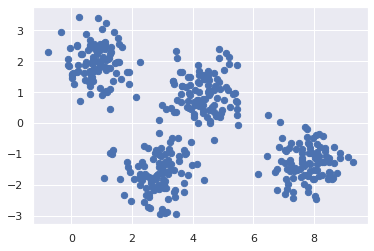

In [ ]:
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.6, 
                       random_state=0)
X = X[:, ::-1] 
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis');

Αν τρέξουμε τον αλγόριθμο των $4$-μέσων, παρατηρούμε ότι ανακαλύπτει συστάδες που ταιριάζουν με αυτές που βρίσκουμε και εμείς οπτικά.

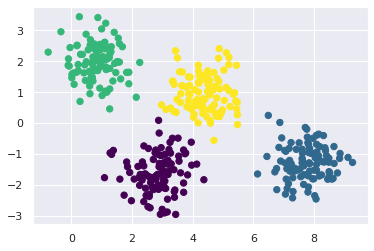

In [ ]:
# Αλγόριθμος 4-μέσων
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

# Σχεδίαση συστάδων
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');


Κοιτάζοντας το παραπάνω σχήμα, μπορούμε να συμπεράνουμε ότι η τοποθέτηση ορισμένων σημείων εντός μιας συστάδας είναι πιο "σίγουρη" από άλλα. Για παράδειγμα, φαίνεται να υπάρχει μια μικρή επικάλυψη μεταξύ των δύο μεσαίων συστάδων (μωβ και κίτρινης), τέτοια ώστε να μην έχουμε απόλυτη εμπιστοσύνη για την χωροθέτηση των σημείων στο όριο τους. Δυστυχώς, ο αλγόριθμος των $k$-μέσων δεν διαθέτει κάποιον εγγενή τρόπο για να μετράει την πιθανότητα (ή την αβεβαιότητα) της ανάθεσης των δειγμάτων στην εκάστοτε συστάδα. 

Ένας τρόπος θεώρησης των αναθέσεων που κάνει ο αλγόριθμος των $k$-μέσων είναι ότι αυτές εντάσσονται σε έναν κύκλο (ή, σε περίπτωση περισσότερων διαστάσεων, σε μια υπερ-σφαίρα) με κέντρο το κέντρο της συστάδας και μήκος ακτίνας που καθορίζεται από το πιο απομακρυσμένο σημείο της. Η ακτίνα αυτή λειτουργεί ως ένα "σκληρό" κατώφλι για τα δείγματα που χαρακτηρίζονται μέλη της συστάδας: κάθε σημείο που βρίσκεται εκτός του κύκλου δεν θεωρείται μέλος.

Μπορούμε να οπτικοποιήσουμε τη συγκεκριμένη ανάθεση, όπως παρακάτω:

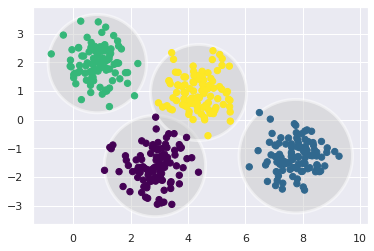

In [ ]:
plot_kmeans(kmeans, X)

Παρατηρούμε δηλαδή πως ο αλγόριθμος των $k$-μέσων κατασκευάζει κυκλικές (σφαιρικές) συστάδες. 

Ας μετασχηματίσουμε τα δεδομένα, "τραβώντας" τα κατά τον άξονα των $x$.

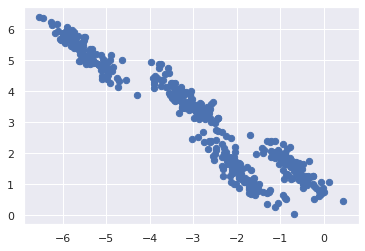

In [ ]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], s=40, cmap='viridis');

Ας ξανατρέξουμε τον αλγόριθμο των $4$-μέσων στα νέα, "τραβηγμένα" δείγματα δεδομένων

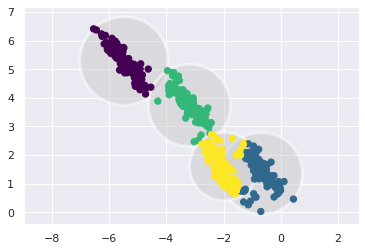

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

Παρατηρούμε ότι πλέον ο αλγόριθμος των $4$-μέσων έχει "ανακατέψει" τα δείγματα εντός των συστάδων και έχει κάνει αναθέσεις στις περιπτώσεις της πράσινης, κίτρινης και μπλε συστάδας που δεν είναι σύμφωνες με αυτό που παρατηρούμε εμείς οπτικά.

Αυτό οφείλεται στο γεγονός ότι οι νέες συστάδες που έχουν δημιουργηθεί μετά τον μετασχηματισμό των δεδομένων έπαψαν πλέον να είναι κυκλικές και έγιναν ελλειψοειδείς. Ωστόσο, ο αλγόριθμος των $k$-μέσων δεν μπορεί να προσαρμοστεί στη νεά δομή των δεδομένων: αντίθετα προσπαθεί να τα κάνει να χωρέσουν εντός των 4 κυκλικών συστάδων κάνοντας εν τέλει αναθέσεις που δεν τις θεωρούμε ορθές. 

Μια λύση σε αυτό το πρόβλημα θα μπορούσε να είναι η χρήση τεχνικών όπως η ανάλυση κυρίων συνιστωσών (principal component analysis - PCA) για να προβάλλουμε τα δεδομένα μας σε ένα νέο χώρο, όπου θα είναι περισσότερο κυκλικά. Ωστόσο, αυτή η πρακτική δεν είναι εγγυημένο ότι θα λειτουργεί σε κάθε περίπτωση.

Συνεπώς, χρειάζεται να βρούμε τρόπους αντιμετώπισης των δύο κύριων αδυναμιών του αλγορίθμου των $k$-μέσων:

1.   Της έλλειψης προσαρμοστικότητας, όσον αφορά το σχήμα των συστάδων.
2.   Της μη-πιθανοτικής ανάθεσης των δειγμάτων στις συστάδες.

Αυτές τις δύο αδυναμίες αντιμετωπίζει μια άλλη κατηγορία αλγορίθμων συσταδοποίησης, τα γκαουσιανά μοντέλα μείξης.

## Τα γκαουσιανά μοντέλα μείξης

Ένα γκαουσιανό μοντέλο μείξης προσπαθεί να βρει μια μείξη πολυδιάστατων γκαουσιανών κατανομών, οι οποίες μπορούν να μοντελοποιήσουν κάθε σύνολο δεδομένων.

Στην απλούστερη περίπτωση, τα GMM μπορούν να χρησιμοποιηθούν για την εύρεση παρόμοιας μορφής συστάδων (σφαιρικές) με τον αλγόριθμο των $k$-μέσων.

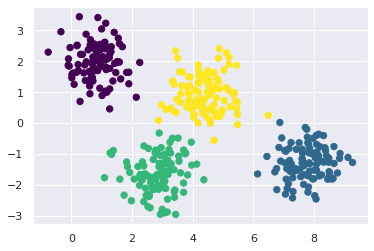

In [ ]:
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Ωστόσο, ο πιθαντικός τους χαρακτήρας τους επιτρέπει να κάνουν (πιθανοτικές) αναθέσεις. Στην περίπτωση του scikit-learn, αυτό υλοποιείται με την μέθοδο ``predict_proba``, η οποία επιστρέφει έναν πίνακα μεγέθους ``[n_samples, n_clusters]``, που περιέχει την πιθανότητα ενός σημείου να ανήκει σε μια συστάδα.

In [ ]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


Μπορούμε να οπτικοποιήσουμε αυτή την πιθανότητα (ή εναλλακτικά ασάφεια), μεταβάλλοντας για κάθε σημείο την ακτίνα του ανάλογα με τη βεβαιότητα τις πρόβλεψης.


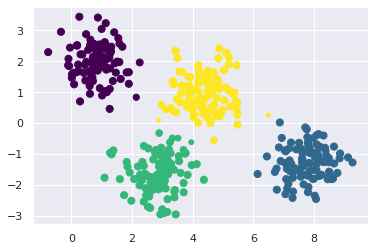

In [ ]:
# ο τετραγωνισμός της πιθανότητας θα κάνει πιο εμφανείς τις διαφορές
size = 50 * probs.max(1) ** 2  
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Έτσι, στο παραπάνω σχεδιάγραμμα, τα σημεία που είναι στο όριο μεταξύ των δύο συστάδων στο κέντρο, έχουν μικρότερη ακτίνα.

Γενικότερα, τα GMM λειτουργούν όπως και ο αλγόριθμος των $k$-μέσων, δηλαδή βασίζονται σε μια διαδικασία αναμονής-μεγιστοποίησης (expectation-maximation ή EM), της οποίας τα βήματα περιγράφονται σε αδρές γραμμές παρακάτω:

1. Ξεκίνα με μια αρχική υπόθεση για την θέση και το σχήμα των συστάδων

2. Επανέλαβε τα δύο παρακάτω βήματα μέχρι τη σύγκλιση:

   1. Βήμα *Αναμονής* (expectation): για κάθε δείγμα, βρες τα βάρη που κωδικοποιούν την πιθανότητα συμμετοχής του κάθε δείγματος σε κάθε συστάδα
   2. Βήμα *Μεγιστοποίησης* (maximization): Ενημέρωσε την τοποθεσία και το σχήμα της κάθε συστάδας, χρησιμοποιώντας **όλα** τα δείγματα δεδομένων
   
Το αποτέλεσμα αυτής της διαδικασίας είναι ότι πλέον η κάθε συστάδα δεν χαρακτηρίζεται από μια σφαίρα με σκληρό κατώφλι, αλλά από ένα πιο ομαλό γκαουσιανό μοντέλο. 

Όπως και στην περίπτωση του αλγορίθμου $k$-μέσων, τα GMM ενδέχεται να μην προσεγγίσουν τη βέλτιστη λύση και για αυτό το λόγο στην πράξη απαιτούνται πολλαπλές τυχαίες αρχικοποιήσεις. 

Ας σχεδιάσουμε τις περιοχές των δεδομένων που εντοπίζει το γκαουσιανό μας μοντέλο

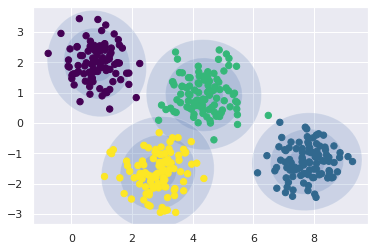

In [ ]:
plot_gmm(gmm, X)

Όπως και προηγουμένως, ας δοκιμάσουμε να συσταδοποιήσουμε με GMM τα "τραβηγμένα" δεδομένα

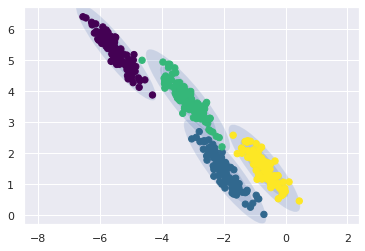

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Παρατηρούμε ότι τα GMM προσαρμόστηκαν στα χαρακτηριστικά των δεδομένων μας, πετυχαίνοντας σχεδόν βέλτιστη συσταδοποίηση. Συνεπώς, μπορούμε να ισχυριστούμε ότι τα GMM αντιμετώπισαν επιτυχώς και τις δύο κύριες αδυναμίες του αλγορίθμου των $k$-μέσων

### Επιλογή του τύπου της συνδιασποράς

Μια πιο προσεκτική ματιά στα αμέσως προηγούμενα κελιά κώδικα, μας φανερώνει ότι η παράμετρος ``covariance_type`` άλλαξε στις διαφορετικές περιπτώσεις.

Η συγκριμένη επιλογή καθορίζει τους βαθμούς της ελευθερίας όσον αφορά το σχήμα κάθε συστάδας και για αυτό πρέπει να καθορίζεται προσεκτικά, ανάλογα με την περίσταση. Η default τιμή της είναι ``covariance_type="diag"``, το οποίο επιτρέπει το μέγεθος της συστάδας να καθορίζεται ανεξάρτητα σε κάθε διάσταση, ωστόσο οι άξονες της έλλειψης θα πρέπει να ευθυγραμμίζονται με τους άξονες των δεδομένων.

Στην περίπτωση που θέσουμε ``covariance_type="spherical"``, τότε το μέγεθος της κάθε συστάδας θα πρέπει να είναι ίδιο σε όλες τις διαστάσεις, οπότε και οδηγούμαστε σε σφαιρικές συστάδες. 

Τέλος, στην περίπτωση που θέσουμε ``covariance_type="full"``, τότε η κάθε συστάδα μπορεί να λάβει ένα ελλειψοειδές σχήμα οποιουδήποτε προσανατολισμού. 

![(Covariance Type)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.12-covariance-type.png?raw=1)

## Χρήση των GMM ως εκτιμητών πυκνότητας

Παρότι τα GMM μπορούν να συσταδοποιήσουν ένα χώρο δεδομένων η πρωταρχική τους χρήση είναι ως *εκτιμητές πυκνότητας*, δηλαδή ως παραγωγικά πιθανοτικά μοντέλα (generative probabilistic models) τα οποία περιγράφουν την κατανομή των δεδομένων.

Αυτό γίνεται ευκολότερα κατανοητό στο παρακάτω παράδειγμα, όπου δημιουργούμε συνθετικά δεδομένα με την χρήση της μεθόδου ``make_moons`` του scikit-learn

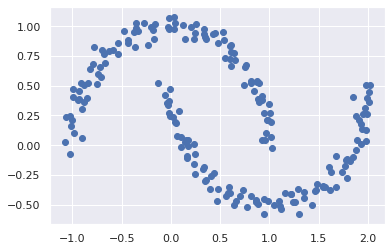

In [ ]:

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Αν προσπαθήσουμε να συσταδοποιήσουμε αυτόν τον χώρο με ένα GMM 2 στοιχείων, τότε το αποτέλεσμα που παίρνουμε δεν είναι ικανοποιητικό

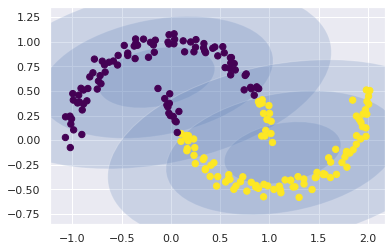

In [ ]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Αν, ωστόσο, χρησιμοποιήσουμε περισσότερα στοιχεία και αγνοήσουμε τις ετικέτες των δεδομένων, λαμβάνουμε μια πολύ ικανοποιητική προσέγγιση της κατανομής του χώρου δεδομένων

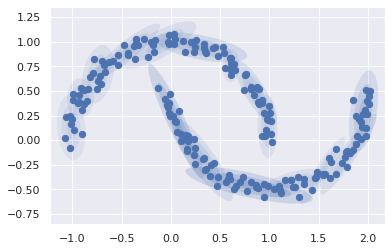

In [ ]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Σε αυτή την περίπτωση, η μείξη 16 γκαουσιανών δεν μας βοηθά στο να συσταδοποιήσουμε τον χώρο, αλλά να μοντελοποιήσουμε την ολική *κατανομή* των δειγμάτων. Άρα παίρνουμε ένα παραγωγικό μοντέλο της κατανομής, υπό την έννοια ότι τα GMM μας δίνουν τη δυνατότητα να δημιουργήσουμε νέα δείγματα δεδομένων, τα οποία υπακούν στην κατανομή των δεδομένων που ήδη έχουμε.

Συμπερασματικά, μπoρούμε να ισχυριστούμε ότι με τα GMM μπορoύμε να μοντελοποιήσουμε την οποιαδήποτε (πολυδιάστατη) κατανομή δεδομένων.

### Προσδιορισμός του πλήθους των στοιχείων

Ένα ζήτημα που προκύπτει είναι ο ακριβής προσδιορισμός του πλήθους των στοιχείων που χρειάζονται για να προσεγγίσουν την υποκείμενη κατανομή των δεδομένων. Είδαμε πως στην περίπτωση που χρησιμοποιούμε λίγα στοιχεία, έχουμε ένα είδος υπο-προσαρμογής (underfitting). 

Αν, ωστόσο, το πλήθος των στοιχείων είναι πολύ μεγαλύτερο, τότε μπορεί πολύ εύκολα να καταλήξουμε στο άλλο άκρο, αυτό της υπερ-προσαρμογής (overfitting), δηλαδή πλέον να μην προσεγγίζουμε τη συνολική *πιθανοφάνεια* των δεδομένων, αλλά την πιθανότητα ύπαρξης συγκεκριμένων δειγμάτων δεδομένων.

Για να αποφύγουμε αυτές τις δύο περιπτώσεις, συνήθως χρησιμοποιούμε ορισμένα κριτήρια, όπως τα [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) ή το  [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion). Και τα δύο προαναφερόμενα κριτήρια υποστηρίζονται απ' την κλάση ``GaussianMixture`` του scikit-learn, οπότε θα σχεδιάσουμε τις τιμές τους ανάλογα με το πλήθος των στοιχείων του μοντέλου.

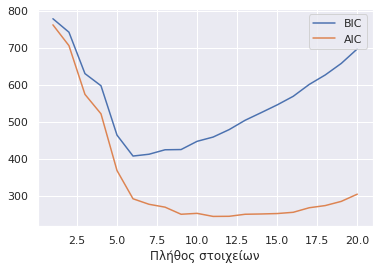

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Πλήθος στοιχείων');

Το βέλτιστο πλήθος των στοιχείων είναι αυτό που ελαχιστοποιεί είτε το AIC είτε το BIC, ανάλογα με το ποια προσέγγιση χρησιμοποιούμε σε κάθε περίπτωση. Σύμφωνα με το AIC η βέλτιστη επιλογή είναι γύρω στα 12 στοιχεία, ενώ σύμφωνα με το BIC, η βέλτιστη επιλογή είναι τα 5 στοιχεία (εν γένει, το BIC προτείνει απλούστερα μοντέλα σε σύγκριση με το AIC).

Ας σχεδιάσουμε παρακάτω και τις δύο περιπτώσεις, ξεκινώντας με το απλούστερο μοντέλο

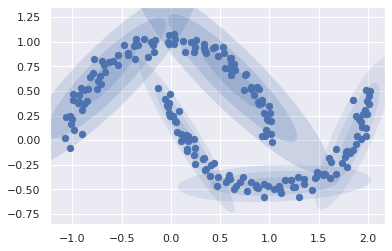

In [ ]:
gmm5 = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
plot_gmm(gmm5, Xmoon, label=False)

Τέλος, ας σχεδιάσουμε το βέλτιστο παραγωγικό μοντέλο σύμφωνα με το AIC

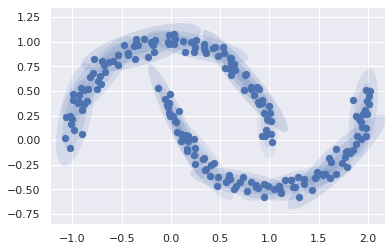

In [ ]:
gmm12 = GaussianMixture(n_components=12, covariance_type='full', random_state=0)
plot_gmm(gmm12, Xmoon, label=False)

## Δημιουργία νέων δεδομένων με το GMM

Μέχρι στιγμής, έχουμε δει πως τα GMM χρησιμοποιούνται για τη συσταδοποίηση δεδομένων καθώς και ως εκτιμητές πυκνότητας. Στη συνέχεια, θα δούμε και πως μπορούν να λειτουργήσουν ως παραγωγικά μοντέλα, δημιουργώντας νέα δείγματα δεδομένων σύμφωνα με την υποκείμενη κατανομή που έχουν προσεγγίσει.

Στο παράδειγμα που ακολουθεί, θα φορτώσουμε ένα σύνολο δεδομένων οπτικής αναγνώρισης χαρακτήρων (optical character recognition - OCR) και πιο συγκεκριμένα, αριθμητικών ψηφίων, όπως αυτά έχουν γραφτεί από διαφορετικούς ανθρώπους. Επίσης θα εμφανίσουμε τα πρώτα 100 από αυτά

(1797, 64)


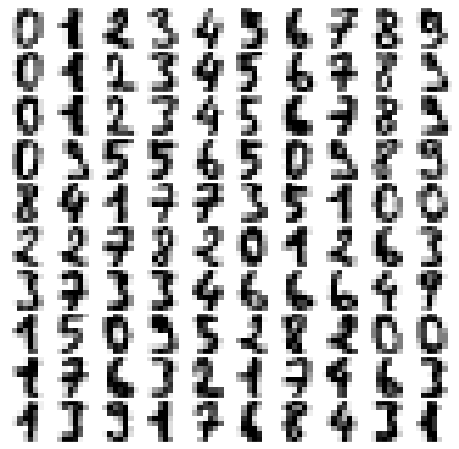

In [ ]:
digits = load_digits()
print(digits.data.shape)
plot_digits(digits.data)

Συνολικά έχουμε σχεδόν 1.800 ψηφία σε 64 διαστάσεις και επιθυμούμε να φτιάξουμε ένα GMM για να μπορούμε να δημιουργούμε δικά μας ψηφία. Επειδή σε ένα τόσο μεγάλο χώρο το GMM ενδέχεται να καθυστερήσει πολύ, πρώτα θα τα απεικονίσουμε σε ένα χώρο μικρότερων διαστάσεων, χρησιμοποιώντας PCA και ζητώντας να διατηρηθεί στο νέο χώρο το 97% της διακύμανσης των αρχικών δεδομένων

In [ ]:
pca = PCA(0.97, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 34)

Βλέπουμε ότι πετυχαίνουμε μια μείωση των διαστάσεων σχεδόν στο μισό, με ελάχιστη απώλεια πληροφορίας. Σε αυτόν τον μειωμένο χώρο διαστάσεων, ας χρησιμοποιήσουμε το κριτήριο AIC για να προσεγγίσουμε το πλήθος των στοιχείων του GMM

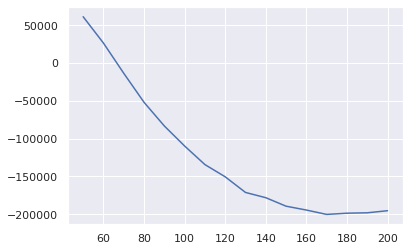

In [ ]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) 
for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

Απ' ότι φαίνεται, το κριτήριο αυτό ελαχιστοποιείται γύρω στα 150 στοιχεία, τα οποία και θα χρησιμοποιήσουμε.

In [ ]:
gmm = GaussianMixture(150, covariance_type='full', random_state=0)
gmm.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=150, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Κατόπιν θα δειγματοληπτίσουμε 100 νέα δείγματα δεδομένων, χρησιμοποιώντας το GMM ως παραγωγικό μοντέλο

In [ ]:
data_new = gmm.sample(len(data))
t1 = data_new[0]

Τέλος θα χρησιμοποιήσουμε τον αντίστροφο μετασχηματισμό για να μεταβούμε από το χώρο των χαμηλότερων διαστάσεων στον αρχικό χώρο και θα εμφανίσουμε τα ψηφία που δημιουργήσαμε

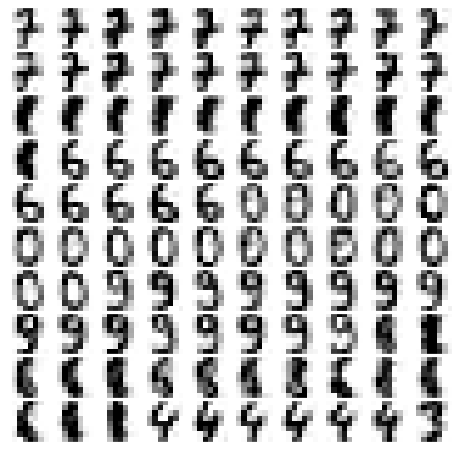

In [ ]:
digits_new = pca.inverse_transform(t1)
plot_digits(digits_new)

Από το αποτέλεσμα μπορούμε να κρίνουμε πως φαίνονται σαν κανονικά ψηφία του συνόλου δεδομένων μας (και όχι ως θόρυβος)!

Συνοψίζοντας, αυτό που πετύχαμε στη συγκεκριμένη περίπτωση είναι το εξής: μοντελοποιήσαμε την υποκείμενη κατανομή δεδομένων ενός δείγματος χειρόγραφων αριθμητικών ψηφίων με ένα GMM και έτσι μπορέσαμε να παράξουμε νέα χειρόγραφα ψηφία, τα οποία δεν υπάρχουν στην αρχική συλλογή δεδομένων. Με άλλα λόγια, κατορθώσαμε να μάθουμε τα στατιστικά χαρακτηριστικά των χειρόγραφων ψηφίων.